In [1]:
#Import libraries
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools as iter
import matplotlib.colors as color
from _collections_abc import Callable
from io import StringIO
import functools
import collections
import operator
from math import sqrt
from scipy.stats import pointbiserialr
sb.set()
plt.show()

In [2]:
dataPull = pd.read_csv("archive//cardio_train.csv", delimiter=";")
dataPull.head()
%store dataPull

Stored 'dataPull' (DataFrame)


In [3]:
dataPull.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [4]:
#This data is pulled from: 
#https://www.kaggle.com/code/bhargavi35/starter-cardiovascular-disease-dataset-d2fc2521-9

# Description
Features:

Age | Objective Feature | age | int (days) <br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary |<br>
Alcohol intake | Subjective Feature | alco | binary |<br>
Physical activity | Subjective Feature | active | binary |<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |<br>

In [5]:
"""Holder class"""
class Holder:
    
    dicthldr = {}
    
    def __init__(self, dicthd : dict):
        self.dicthldr = dicthd
    
    def get(self, getType):
        return self.dicthldr[getType]
    
    def updateTo(self, fn : dict):
        self.dicthldr.update(fn)
"""Shortform class"""
# #function to convert cats to short-form. Meow. 
class Shortform:
    
    catlist = []
    
    def __init__(self, listf : list):
        self.catlist = listf
        
    def shorter(self, inputstr : str):
        if inputstr == self.catlist[5]:
            return 'Gdr'
        elif inputstr == self.catlist[6]:
            return 'Chol'
        elif inputstr == self.catlist[7]:
            return 'Gluc'
        elif inputstr == self.catlist[1]:
            return 'Female' #no change
        elif inputstr == self.catlist[2]:
            return 'Male'
        elif inputstr == self.catlist[3]:
            return 'Norm'
        elif inputstr == self.catlist[0]:
            return 'AbvNm'
        elif inputstr == self.catlist[4]:
            return 'WellAbvNm'
        elif inputstr == self.catlist[8]:
            return 'Alcohol'
        elif inputstr == self.catlist[9]:
            return 'Active'
        elif inputstr == self.catlist[10]:
            return 'Smoking'
        elif inputstr == self.catlist[11]:
            return 'Yes'
        elif inputstr == self.catlist[12]:
            return 'No'
        else:
            return ''


In [6]:
#We need to change the categorical variables [gender, chol, gluc] and change the binary forms to TRUE and FALSE.
categorical_src = ['gender', 'cholesterol', 'gluc']
binForm_src = ["smoke", "alco", "active", "cardio"]
#Store maps and arrays here to deliver to holder store class. 
mapGenderFrom_src = [1, 2]
mapGenderTo_src = ['Female', 'Male']
mapGlucFrom_src = [1, 2, 3]
mapGlucTo_src = ['Norm', 'AbvNorm', 'WellAbvNorm']
mapCholFrom_src = [1, 2, 3]
mapCholTo_src = ['Norm', 'AbvNorm', 'WellAbvNorm']
V = Holder({
    #extras because I am known to shorten/lengthen things and not know it myself.
    'categorical' : categorical_src, 'cat' : categorical_src,
    'binary' : binForm_src, 'bin' : binForm_src,
    'genderFrom' : mapGenderFrom_src,
    'genderTo' : mapGenderTo_src,
    'glucFrom' : mapGlucFrom_src,
    'glucTo' : mapGlucTo_src,
    'cholFrom' : mapCholFrom_src, 'cholesterolFrom' : mapCholFrom_src,
    'cholTo' : mapCholTo_src, 'cholesterolTo' : mapCholTo_src
    })
#The aim is to never use the individual lists here, but use V only. 
#Store to algop
dictOutput = V.dicthldr
%store dictOutput
#send labels to shortform class. 
stfm = Shortform(['AbvNorm', 'Female', 'Male', 'Norm', 'WellAbvNorm', 'gender', 'cholesterol', 'gluc', 'alco', 'active', 'smoke', 'Yes', 'No'])

Stored 'dictOutput' (dict)


In [7]:
"""Utility Functions all here. """
def convertToBin(binary_slot : list, dataIn):
    """Convert the data in dataIn(1s to 0s) to True and False"""
    #first, copy the dataframe so upstream doesn't suffer. 
    data_tmp = dataIn.copy()
    data_tmp[binary_slot] = data_tmp[binary_slot].astype('bool')
    return data_tmp #I do not care about SettingWithCopyWarning. 
#Warning: This function will overwrite all instances of dataIn. Use at your own risk. 
def mapdat(dataIn, columns_in : list, map_from : list, map_to : list):
    """Map from one list of values to another. I tried to use lambda functions but python is hard.
    Warning: This function overwrites the instance of dataIn. You would better know what you are doing if you
    use this."""
    for col in columns_in:
        for i in range(dataIn.shape[0]):
            content = dataIn[col][i]
            for j in range(len(map_from)):
                if content == map_from[j]:
                    content = map_to[j]
            dataIn[col][i] = content
#create dictionary from array input :: for downstream. May not be used after refactor and clean up. 
def getDictFromListMapper(map_from : list , map_to : list):
    retDict = {}
    for t in zip(map_from, map_to):
        retDict.update({t[0] : t[1]})
    return retDict
def filterOut(filter_cond : list, dataMatrix):
    """Filter out useless data from the dataMatrix."""
    k = [x for x in dataMatrix.columns if x not in filter_cond]
    return pd.DataFrame(dataMatrix[k])
def pullRange(typeb : str, dataPullIn):
    """Print out the range of data pull for typeb into an output txt file for me to determine extreme outliers."""
    typedecode = "systolic" if typeb == "ap_hi" else "diastolic"
    s_k0 = dataPullIn[typeb].value_counts(ascending=True)
    s_k1 = list(s_k0.keys())
    s_k1.sort(reverse=True)
    f = open("output.txt", "w")
    f.write(typeb + " Value : Frequency\r\n")
    f.write(typeb + " is " + typedecode + " blood pressure.\n")
    for i in s_k1:
        f.write(str(i) + "--> T::" + str(s_k0[i]) + "\n")
    f.close()
def iteratedGate(lstbool : list[bool]):
    """Helper method for removeErroredNumericals. Take a boolean array and apply iterated or and output notted state"""
    ret = lstbool[0]
    for j in range(1, len(lstbool)):
       ret = ret or lstbool[j]
    return not(ret) 
def removeErroredNumericals(upper : float, 
                            lower : float , 
                            intvl : float, 
                            listSeries : list[str], 
                            dataIn, 
                            FnbtwRows : Callable[[list], bool],
                            FnRangeLim : Callable[[list, float], bool]):
    """Remove entire rows that contain errored numericals as dependent on listSeries. 
    [lower, upper] = range
    FnbtwRows : Returns false if proper values. Processes the list of values at row x with the space determined by listSeries.
    FnRangeLim : Returns false if proper values. Process list of values at row x too. """
    serlist = []
    #get a list of all the series' that will be considered into serlist. 
    for var in listSeries:
        serlist.append(dataIn[var])
    #set up holder for rows to be eliminated from dataIn. 
    L_0 = [] 
    #loop for all rows in dataIn space. 
    for i in range(dataIn.shape[0]):
        #set up holder for the values for each row that has headers as listed in listSeries.
        elems = []
        #get number of series' to be considered, create holder. 
        for j in range(len(listSeries)):
            elems.append(serlist[j][i]) #get the values elin the specific row and store it in the value holder elems. 
        #boolean conditions
        #create a boolean list for processing later. 
        #Elems should be a list of values only len(listSeries) in size. 
        FullCond = []
        FullCond.append(FnbtwRows(elems)) #check condition between values in the elems space. 
        FullCond.append(FnRangeLim(elems, intvl)) #check interval condition in elems space.
        #For each series considered, find out if the values lie in the allowed range. 
        for j in range(len(listSeries)): 
            FullCond.append(elems[j] >= upper) 
            FullCond.append(elems[j] <= lower) 
        if(iteratedGate(FullCond)):
            #append values that makes sense to L_0. 
            L_0.append(i)
    dataout = dataIn.iloc[L_0]
    return dataout.reset_index() #need this if not the dataframe index get messed up with index skips, will cause issue downstream. 
def possibleValues(series : str):
    if series == 'gender':
        return V.get('genderTo')
    elif series == 'gluc':
        return V.get('glucTo')
    elif series == 'cholesterol':
        return V.get('cholTo')
    elif series in V.get('bin'):
        return [1, 0]
    else: 
        return "Key not found."
#grouped absolutes summing function
def groupedAbsSummationDiff(inp):
    """This is NOT a general function. DO NOT USE IT AS SUCH. Only used for diff_df(do reference search)"""
    app = 'DiffTrue_False'
    #create a new dictionary off inp
    dict_arr = []
    for dictionary_entries in inp:
        key_get = list(dictionary_entries.keys())[0]
        elem = abs(dictionary_entries[key_get])
        if 'Female' in key_get or 'Male' in key_get:
            dict_arr.append({'gender' + app : elem})
        elif 'Chol' in key_get:
            dict_arr.append({'cholesterol' + app : elem})
        elif 'Gluc' in key_get:
            dict_arr.append({'glucose' + app : elem})
        elif 'Smoking' in key_get:
            dict_arr.append({'smoking' + app : elem})
        elif 'Alcohol' in key_get:
            dict_arr.append({'drinks' + app : elem})
        elif 'Active' in key_get:
            dict_arr.append({'isActive' + app : elem})
    return dict(functools.reduce(operator.add, map(collections.Counter, dict_arr)))
#Very annoying
def convertBooleanToYN(rengeMiyauchi):
    #check boolean
    if len(rengeMiyauchi) == 2:
        #check text form of True and False
        if (rengeMiyauchi[0] in ['True', 'T'] and rengeMiyauchi[1] in ['False', 'F']) \
        or (rengeMiyauchi[0] in ['False', 'F'] and rengeMiyauchi[1] in ['True', 'T']):
            if rengeMiyauchi[0] in ['T', 'True']:
                rengeMiyauchi[0] = 'Yes'
                rengeMiyauchi[1] = 'No'
            else:
                rengeMiyauchi[1] = 'Yes'
                rengeMiyauchi[0] = 'No'
            return rengeMiyauchi
        #check string 
        if type(rengeMiyauchi[0]) not in [bool, int] or type(rengeMiyauchi[1]) not in [bool, int]:
            return rengeMiyauchi
        #check boolean in terms of int
        if (rengeMiyauchi[0] or rengeMiyauchi[1]) or sum(rengeMiyauchi) == 1 and rengeMiyauchi[0] * rengeMiyauchi[1] == 0:
            if rengeMiyauchi[0] == 1:
                rengeMiyauchi[0] = 'Yes'
                rengeMiyauchi[1] = 'No'
            else:
                rengeMiyauchi[1] = 'Yes'
                rengeMiyauchi[0] = 'No'
    return rengeMiyauchi

In [8]:
pullRange('ap_lo', dataPull)

In [9]:
#get rid of id, it is useless.
filter_k = ["ID ", "id", "id ", "ID"]
data = filterOut(filter_k, dataPull)
data.head(n = 20)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [10]:
testdata = convertToBin(V.get('binary'), data)
#double check. 
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  bool   
 9   alco         70000 non-null  bool   
 10  active       70000 non-null  bool   
 11  cardio       70000 non-null  bool   
dtypes: bool(4), float64(1), int64(7)
memory usage: 4.5 MB


In [11]:
#now the data is proper. Let me display it. 
testdata.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,False,False,True,False
1,20228,1,156,85.0,140,90,3,1,False,False,True,True
2,18857,1,165,64.0,130,70,3,1,False,False,False,True
3,17623,2,169,82.0,150,100,1,1,False,False,True,True
4,17474,1,156,56.0,100,60,1,1,False,False,False,False


In [12]:
#Now I convert ages to approx. years, and height to metres for standardization. 
r = testdata['age'] / 365.24
testdata['age'] = r.astype('int')
testdata['height'] /= 100

In [13]:
#Store testdata 
%store testdata
#Then convert gender to actual gender
mapdat(testdata, [V.get('categorical')[0]], map_from = V.get('genderFrom'), map_to = V.get('genderTo'))
#Convert 1, 2, 3 to normal, above normal and well above normal. 
mapdat(testdata, V.get('categorical')[1:], map_from = V.get('cholFrom'), map_to = V.get('cholTo'))

Stored 'testdata' (DataFrame)


C:\Users\TBNRd\AppData\Local\Temp\ipykernel_18368\861966092.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataIn[col][i] = content


In [14]:
#And we are now ready. 
testdata
#store formatted
formattedtestdata = testdata.copy()
%store formattedtestdata

Stored 'formattedtestdata' (DataFrame)


# Exploratory Analysis
 First, we deal with the categorical variables. General exploration.

In [15]:
cat_data = pd.DataFrame(testdata[V.get('categorical')])
bin_data = pd.DataFrame(testdata[V.get('binary')])
cat_data.head(n = 19)

,gender,cholesterol,gluc
0,Male,Norm,Norm
1,Female,WellAbvNorm,Norm
2,Female,WellAbvNorm,Norm
3,Male,Norm,Norm
4,Female,Norm,Norm
5,Female,AbvNorm,AbvNorm
6,Female,WellAbvNorm,Norm
7,Male,WellAbvNorm,WellAbvNorm
8,Female,Norm,Norm
9,Female,Norm,Norm


In [16]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gender       70000 non-null  object
 1   cholesterol  70000 non-null  object
 2   gluc         70000 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [17]:
cat_data.describe()

,gender,cholesterol,gluc
count,70000,70000,70000
unique,2,3,3
top,Female,Norm,Norm
freq,45530,52385,59479


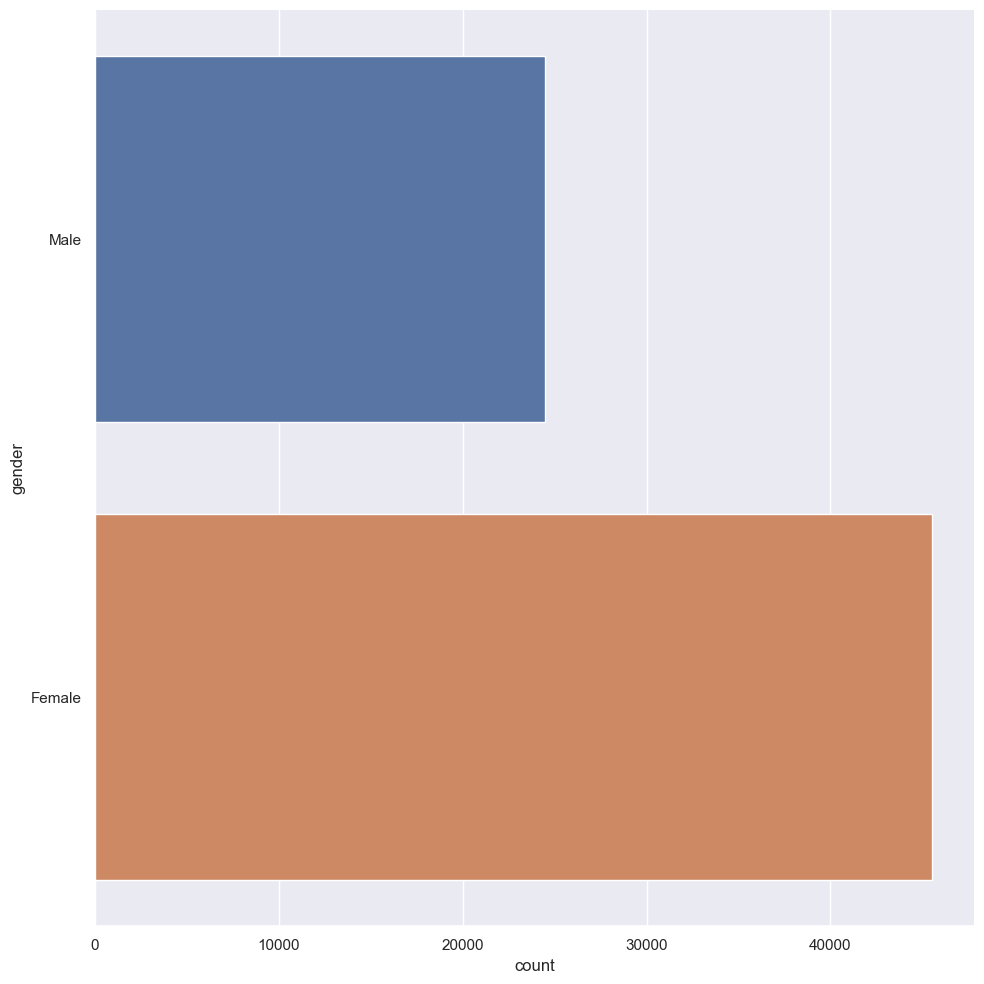

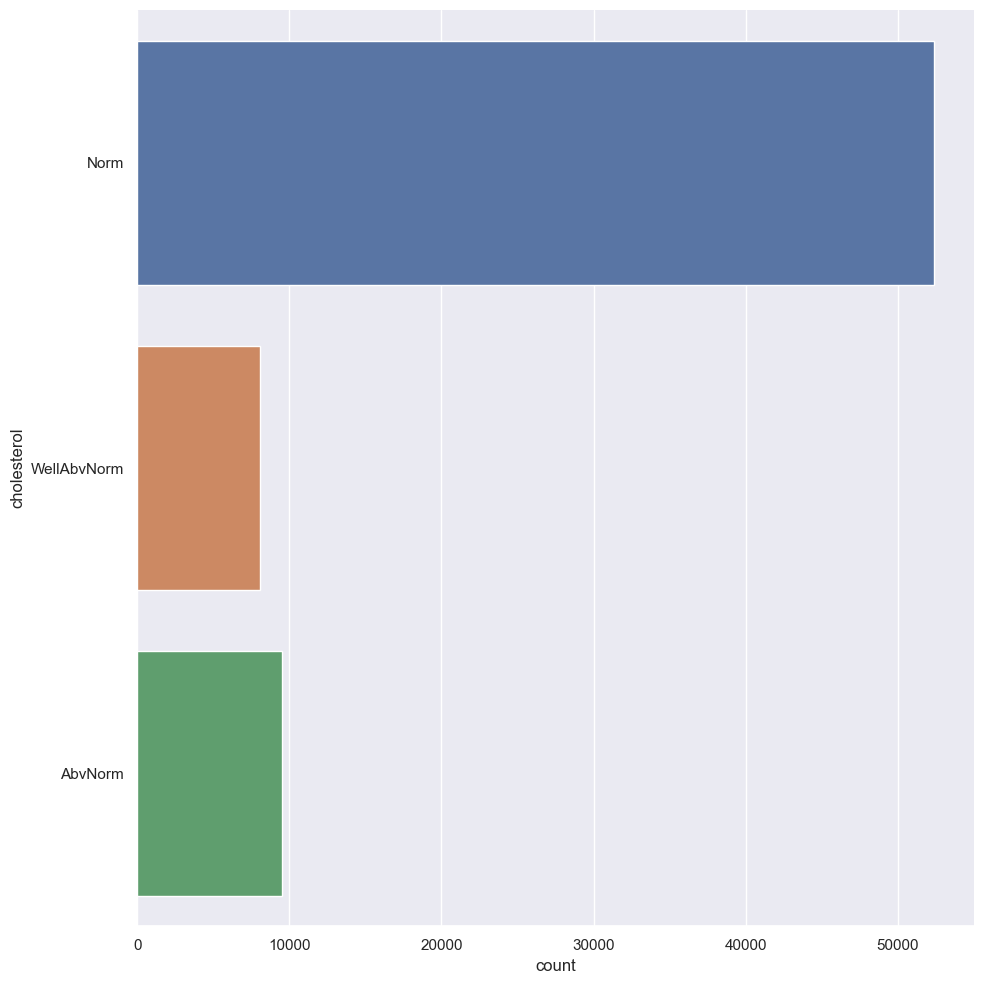

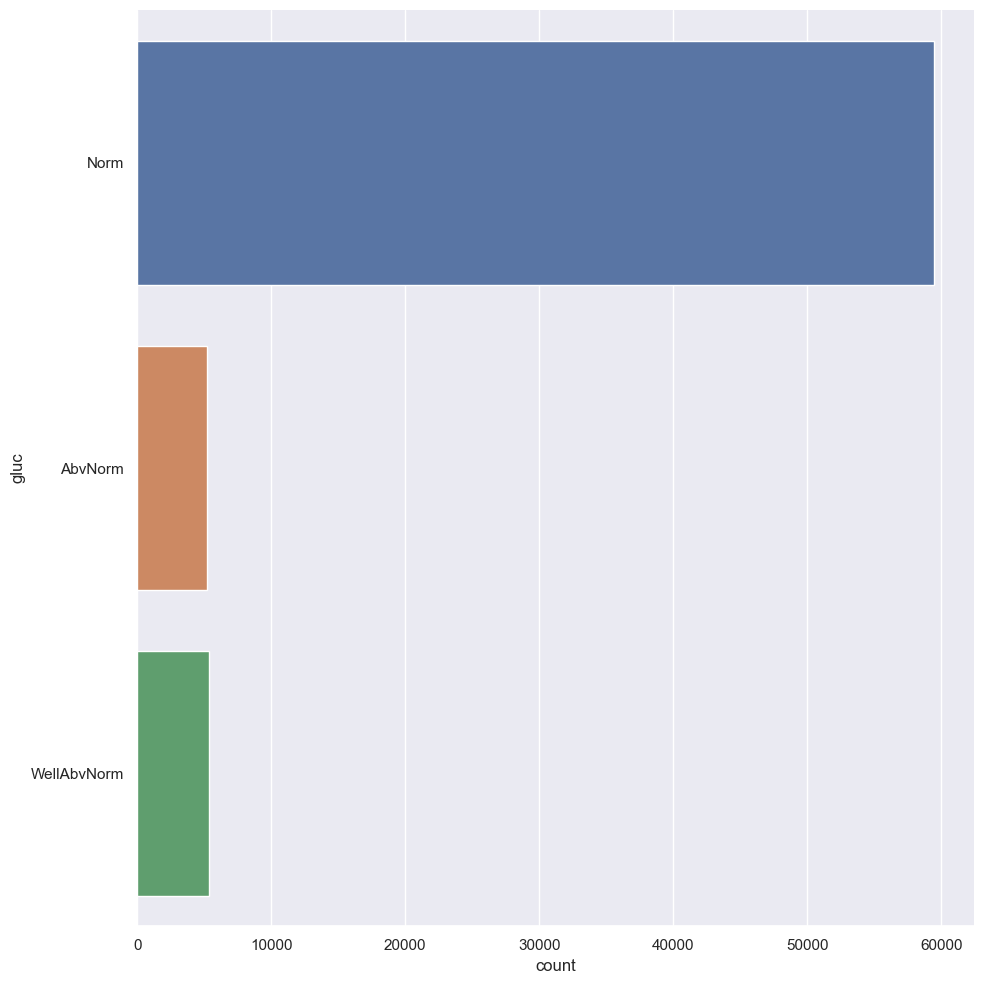

In [18]:
#catplot for all
for i in range(cat_data.shape[1]):
    sb.catplot(y = cat_data.columns[i], data = cat_data, kind = 'count', height = 10)

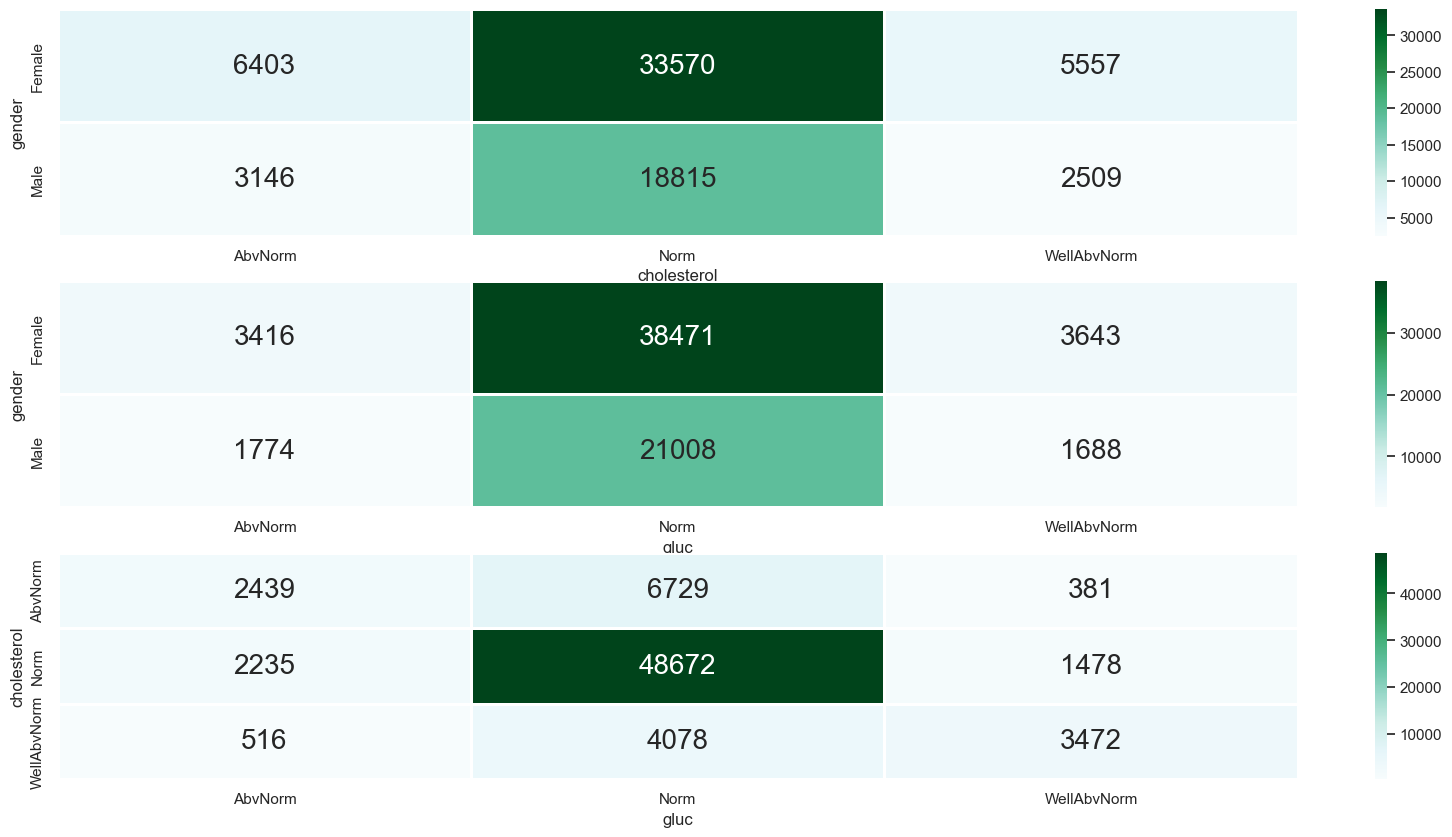

In [19]:
#get possible combinations
comby = list(iter.combinations(cat_data.columns, 2))
#then plot the heatmaps. 
f, axes = plt.subplots(3, 1, figsize = (20, 10))
for i in range(len(comby)):
    sb.heatmap(cat_data.groupby([comby[i][0], comby[i][1]]).size().unstack(),
               linewidths=1, annot=True, fmt='g', annot_kws={"size" : 20}, cmap = "BuGn", ax=axes[i])

Now I deal with the binary stuff

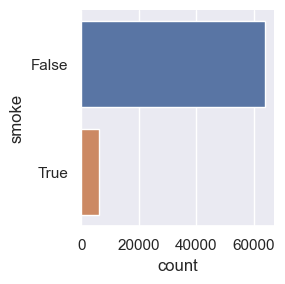

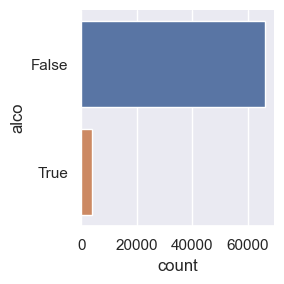

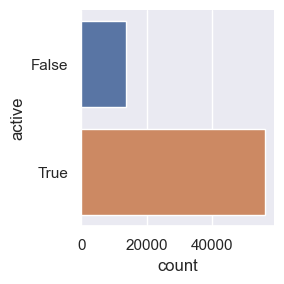

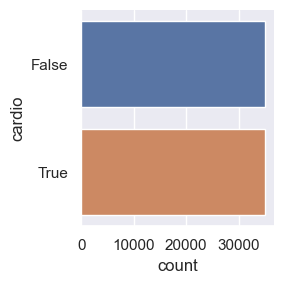

In [20]:
for col in V.get('bin'):
    sb.catplot(y = col, data = bin_data, height = 3, kind = 'count')

Now we deal with numerical data. 

In [21]:
#Let z be the data. 
z = testdata.copy()
#Determine numericals and extended numericals. 
#numericals
num = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
#extended numericals including booleans
j_cat = ['cholesterol', 'gluc', 'gender']
j_bool = j_cat + ['smoke', 'active', 'alco']
ext_num = num + j_bool
z_num = pd.DataFrame(z[num + [z.columns[-1]]])
z_ext = pd.DataFrame(z[ext_num + [z.columns[-1]]])
#store z
%store z

Stored 'z' (DataFrame)


In [22]:
#ignore cardio
z_num.describe()

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,52.804157,1.643592,74.205690,128.817286,96.630414
std,6.762732,0.082101,14.395757,154.011419,188.472530
min,29.000000,0.550000,10.000000,-150.000000,-70.000000
25%,48.000000,1.590000,65.000000,120.000000,80.000000
50%,53.000000,1.650000,72.000000,120.000000,80.000000
75%,58.000000,1.700000,82.000000,140.000000,90.000000
max,64.000000,2.500000,200.000000,16020.000000,11000.000000


In [23]:
pd.DataFrame(z[j_cat]).describe()

,cholesterol,gluc,gender
count,70000,70000,70000
unique,3,3,2
top,Norm,Norm,Female
freq,52385,59479,45530


Now I see the distribution of numerical data. Note that it is not continuous at the scale of thousands, so the kernel density looks very uncharacteristic. 

In [24]:
def doPlotting(dataIn, dataInSlice):
    """
    dataIn : Main data space
    dataInSlice : Main data space slice that determine what gets plotted
    """
    #get a color space.
    color_space = list(color.BASE_COLORS.keys())
    #get the space count.
    z_0 = pd.DataFrame(dataInSlice).columns
    #plot boxplot, histplot and violinplot all in one go
    f, axes = plt.subplots(len(z_0), 3, figsize = (20, 20))
    row = 0
    for s in z_0:
        sb.boxplot(data = dataIn[s], orient = 'h', color = color_space[row], ax = axes[row, 0])
        sb.histplot(data = dataIn[s], kde = True, color = color_space[row], ax = axes[row, 1])
        sb.violinplot(data = dataIn[s], orient = 'h', color = color_space[row], ax = axes[row, 2])
        row += 1

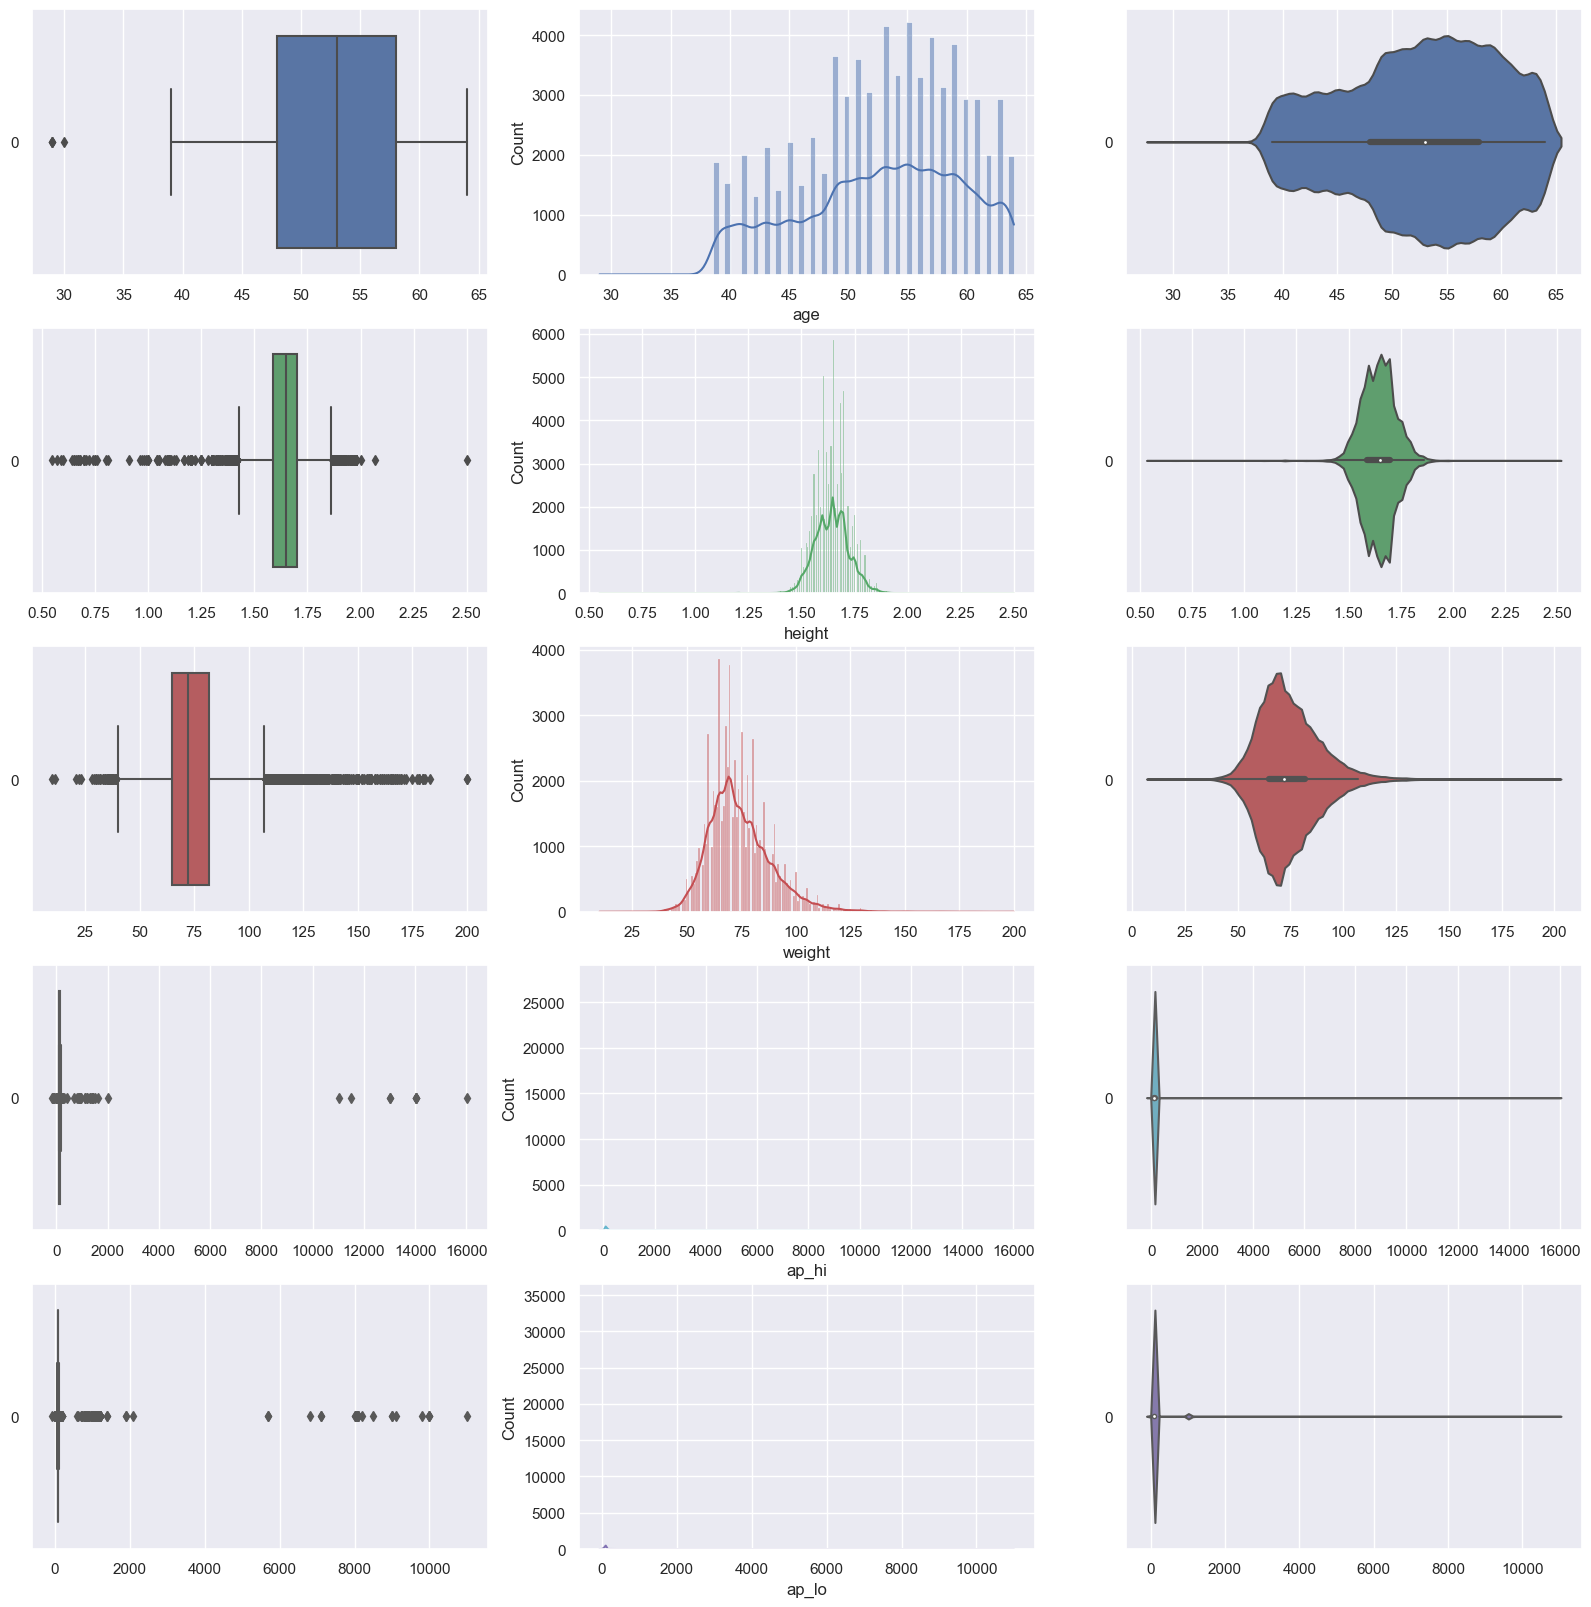

In [25]:
#This takes a thousand eras to run. ~1 minute. 
doPlotting(z, z[num])

We now know that there is an issue with ap_hi and ap_lo. We have to fix the bounding issues, since it should be obvious that blood pressure can't attain values of 400 and above.  

https://rstudio-pubs-static.s3.amazonaws.com/517828_8a3252fe1f604347845517e735a518fe.html#:~:text=The%20variabile%20description%20are%20as,%3A%20well%20above%20normal%20%7C%20gluc%20%3A

### TodoList update
1. Remove ap_hi and ap_lo rows that don't make sense. ap_hi, ap_lo within [0, 360]
2. Do data analysis for the non-categorical type to cardio. <br>
3. Do data analysis for categorical type ['cholesterol', 'gluc', 'Male', 'Smoke', 'alco', 'active'] map to ['cardio']. 

In [26]:
#spot non-congruent data and then remove the rows that it occupies. 
testdataccopy = removeErroredNumericals( 
    360, #inclusive. 
    0, #inclusive. 
    100,
    ['ap_hi', 'ap_lo'],
    z,
    lambda s : s[0] < s[1], #this, under normal numbers, should be false. 
    lambda s, t : s[0] - s[1] > t #this, in range, should be false. 
)
testdataccopy = testdataccopy.drop('index', axis=1)
testdataccopy 
#store testdataccopy
%store testdataccopy

Stored 'testdataccopy' (DataFrame)


In [27]:
#Check if it work or not.
pullRange("ap_lo", testdataccopy)
#convert cardio back to binary, if it is not. 
testdataccopy = convertToBin(['cardio'], testdataccopy)

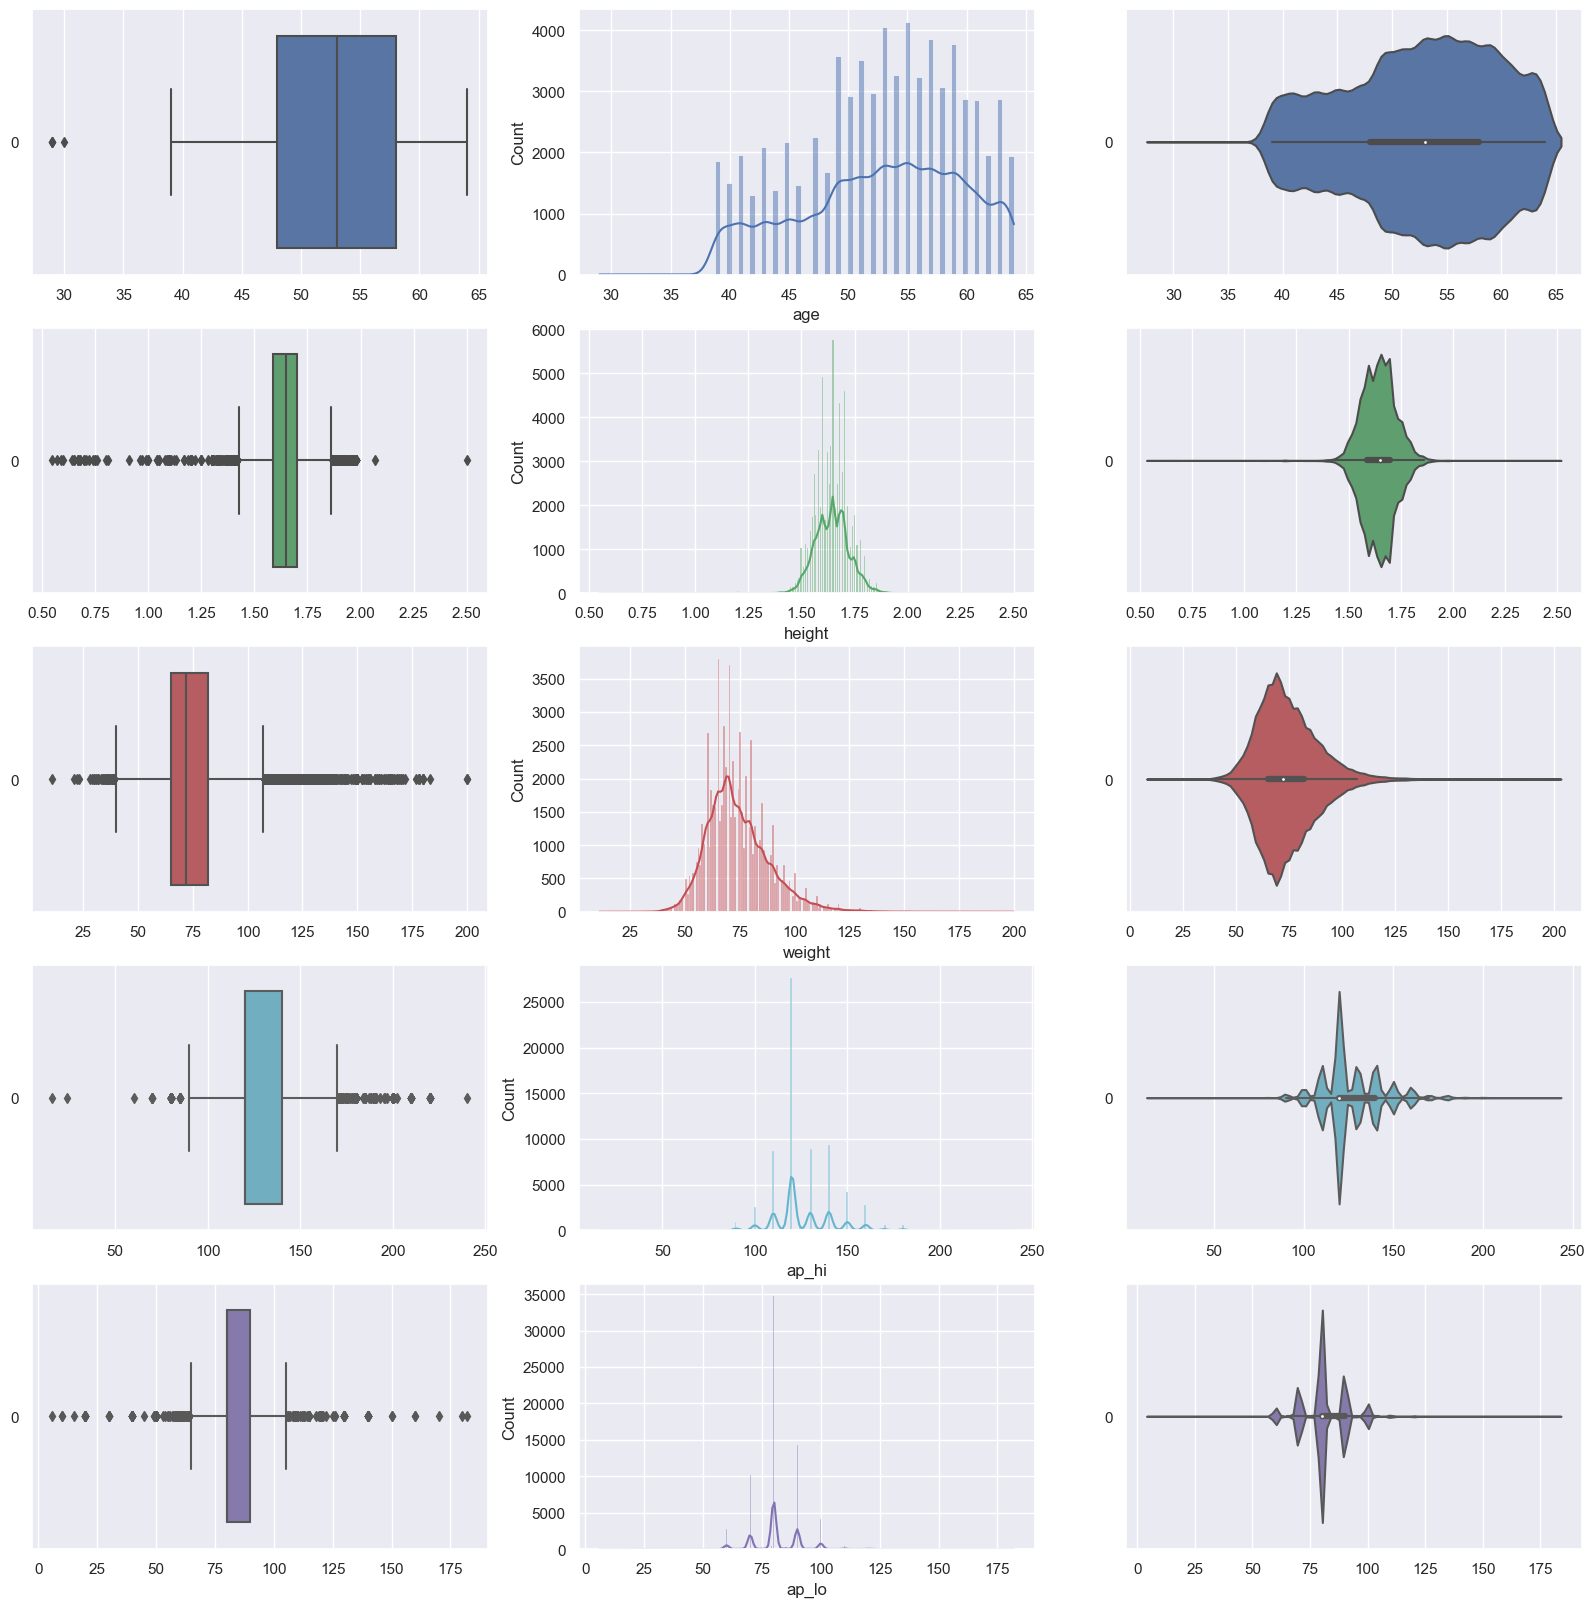

In [28]:
doPlotting(testdataccopy, testdataccopy[num])

Now we do each numerical to cardio

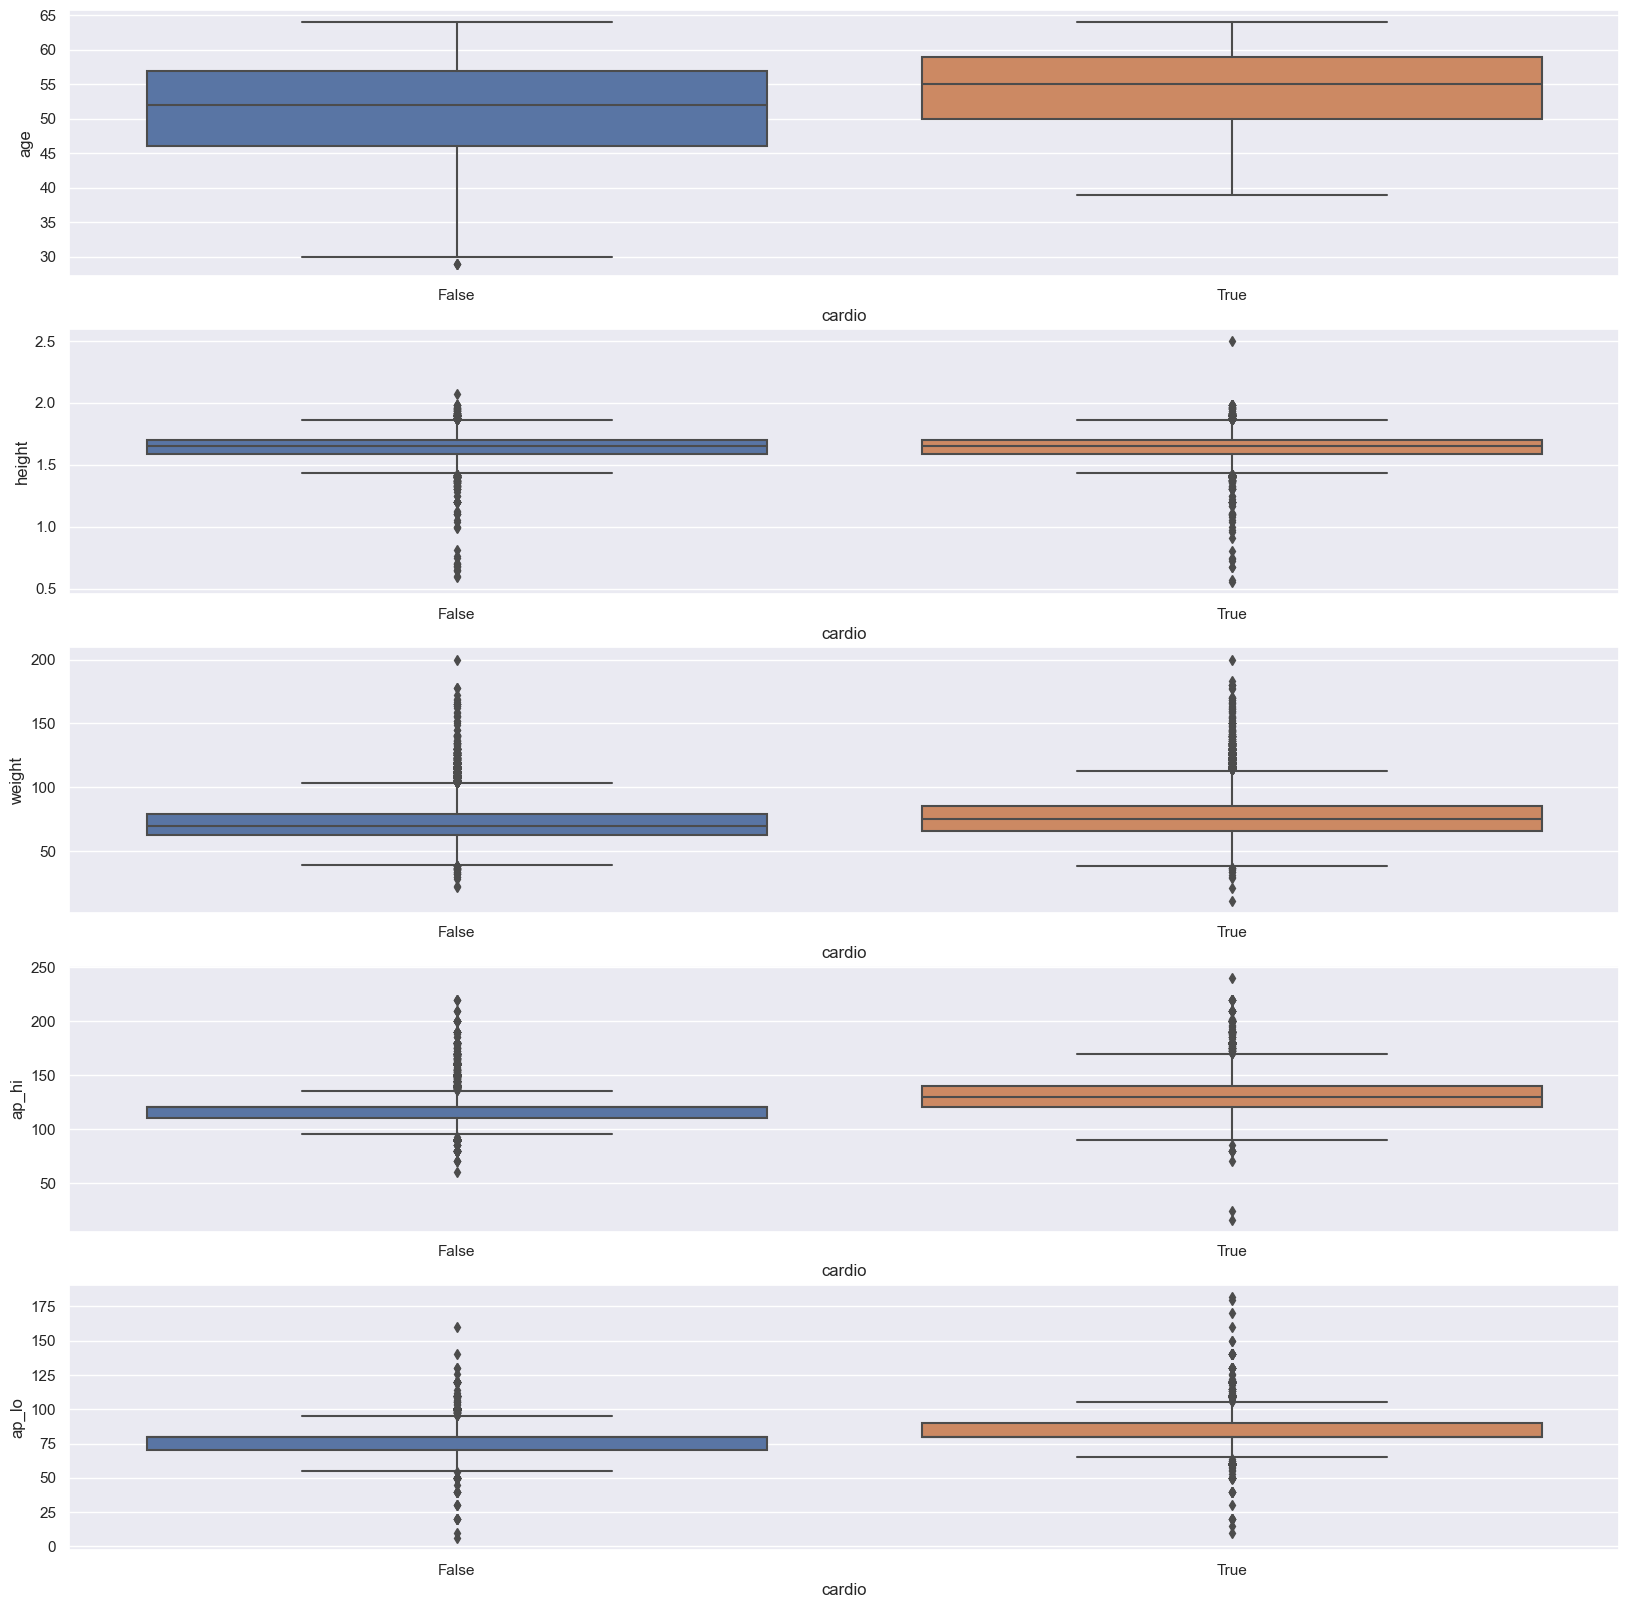

In [29]:
#Do test of numerical to cardio. 
f, axes = plt.subplots(len(num), 1, figsize = (20, 20))
i = 0
for var in num:
    sb.boxplot(x = 'cardio', y = var, data = testdataccopy, ax = axes[i])
    i += 1

<AxesSubplot:xlabel='cardio', ylabel='height'>

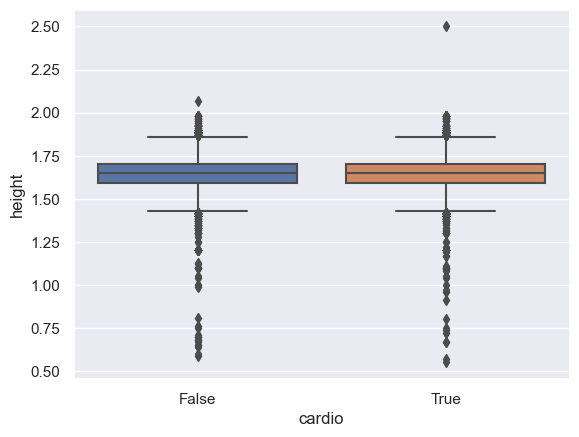

In [30]:
#Particularly height
sb.boxplot(x = 'cardio', y = 'height', data = testdataccopy)

In [31]:
def plotdiffbetweenTF(first : str, second_with_boolean_only : str, show : bool = True):
    """Generate list that contains difference in data description between first_true and first_false according to second.
    The first labels that generate represent labels between ind. lists."""
    dfarr = pd.DataFrame(testdataccopy[[first, second_with_boolean_only]])
    datTrue = []
    datFalse = []
    for i in range(dfarr.shape[0]):
        state : bool = dfarr.iloc[i][1]
        spltht : float = dfarr.iloc[i][0]
        if state :
            datTrue.append(spltht)
        else:
            datFalse.append(spltht)
    datfdesc = pd.DataFrame(datFalse).describe()
    dattdesc = pd.DataFrame(datTrue).describe()
    datdatdatdiff = []
    #difference between the two
    if show:
        print(first + " against " + second_with_boolean_only, end=":\r\n")
    for i in range(len(datfdesc)):
        stattype = datfdesc[0].keys()[i]
        diff = datfdesc[0][i] - dattdesc[0][i]
        dat_0 = int(diff) if stattype=='count' else round(diff, 3)
        datdatdatdiff.append(dat_0)
        #print(stattype.capitalize() + ' difference: ', dat_0)
    return (len(datTrue) - len(datFalse), datdatdatdiff)
#function for special summation. Strict bounded function. 
def sum_of(list_in_real : list[int], function : Callable[[float], float]):
    output_ : float = 0.0
    for i in list_in_real:
        output_ += function(i)
    return output_

In [53]:
#extract the data descriptions from one num variable in [num] to cardio(T/F). 
#Then combine together, ignoring signs
_diff = {}
for var in num:
    diff_ind = plotdiffbetweenTF(var, 'cardio', False)[1]
    #Now we add everything together, not caring about sign convention just to prove a point.
    _diff.update({var : sum_of(diff_ind, abs) - 780})
print(_diff)
min(_diff, key = _diff.get)

{'age': 20.661000000000058, 'height': -1.5270000000001573, 'weight': 29.728000000000065, 'ap_hi': 120.832, 'ap_lo': 51.82499999999993}


'height'

Now we do heatmap and pairplots

ageBuiltIn: 0.23907085910170048
heightBuiltIn: -0.01059641682518866
weightBuiltIn: 0.17961910558420632
ap_hiBuiltIn: 0.42905697614068655
ap_loBuiltIn: 0.3396589189735528
cardioBuiltIn: 0.9999999999998952


<AxesSubplot:>

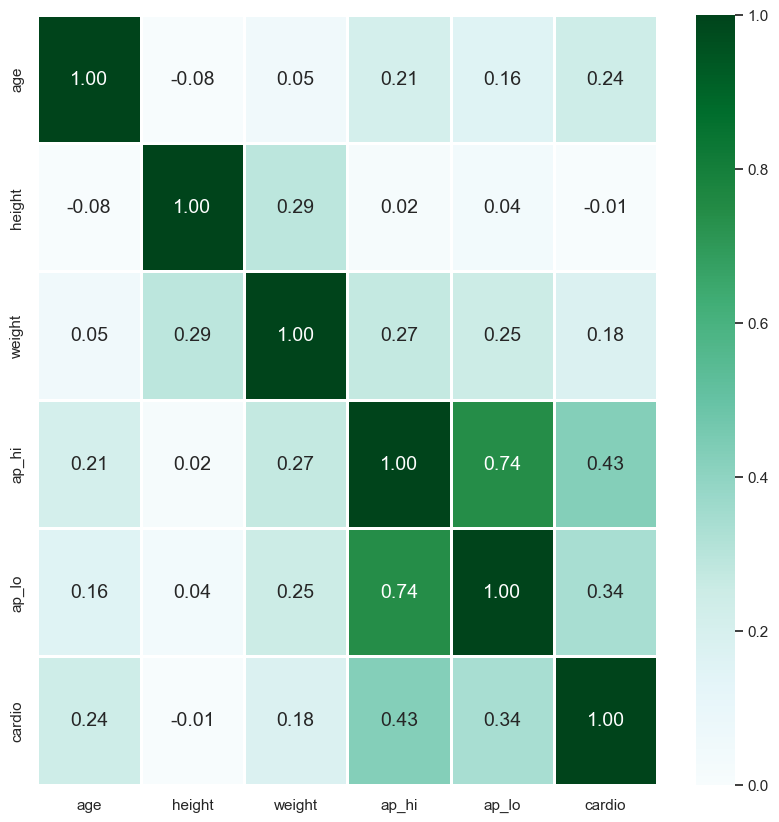

In [33]:
numdat = testdataccopy[num + ['cardio']]
#There is a trick. In Python, False == 0 and True == 1. So we can treat cardio as a numerical, although this is not good.
corr_matr = numdat.corr()
#So, I try to do it properly. With numerical -> binary data, we can use a point-biserial correlation. The function is lifted
#from the internet. 
#credit: https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
def pbc_scratch(binary_data, continuous_data, data):
    """
    Function that computes the point biserial correlation of two pandas data frame columns
    binary_data: name of dichotomous data column
    continuous_data: name of dichotomous data column
    data: dataframe where above columns come from
    returns: Point Biserial Correlation
    """

    bd_unique = data[binary_data].unique()
    
    g0 = data[data[binary_data] == bd_unique[0]][continuous_data]
    g1 = data[data[binary_data] == bd_unique[1]][continuous_data]
    
    s_y = np.std(data[continuous_data])
    n = len(data[binary_data])
    n0 = len(g0)
    n1 = len(g1)
    m0 = g0.mean()
    m1 = g1.mean()
    
    return (m0-m1)*sqrt((n0*n1)/n**2)/s_y
for i in range(corr_matr.shape[0]):
    #pbc_out =  pbc_scratch('cardio', corr_matr.iloc[i].name, numdat)
    #print(corr_matr.iloc[i].name + 'Homemade pbc:' , pbc_out)
    pbc_out = pointbiserialr(numdat['cardio'], numdat[corr_matr.iloc[i].name]).correlation
    print(corr_matr.iloc[i].name + 'BuiltIn:', pbc_out)
    replacement = pbc_out
#But it seems that corr() comes out with the same values. Perhaps corr() is truly a one-size fit all approach. I run with it.
corr_matr
#draw heatmap
f, axes = plt.subplots(1, 1, figsize=(10, 10))
sb.heatmap(corr_matr, vmin = 0, vmax = 1,  linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 14}, cmap = "BuGn")

Lastly, I draw the pairplots. Which should, and do look incredibly odd. 

C:\Users\TBNRd\AppData\Local\Temp\ipykernel_18368\249871650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numdat['cardio'] = numdat['cardio'] * 100


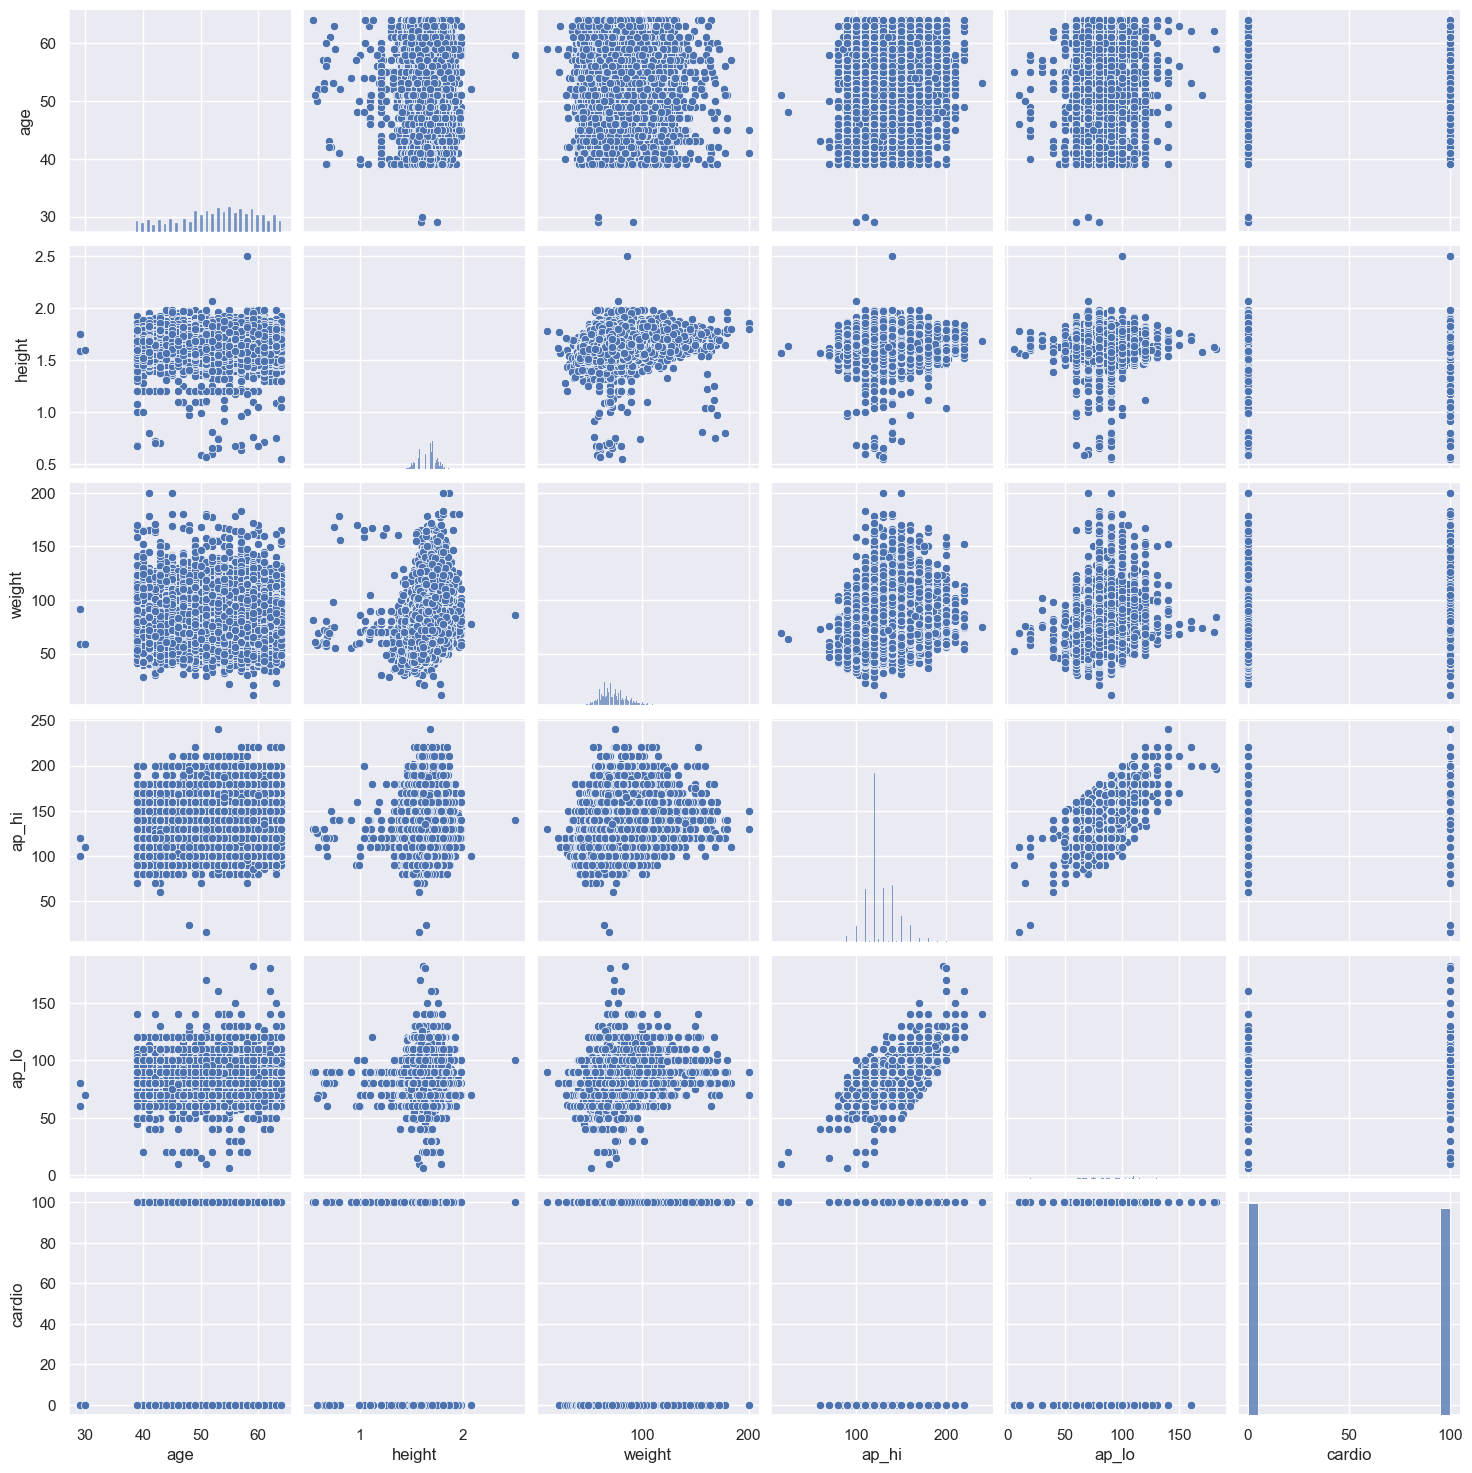

In [34]:
#need to make cardio more numeric like or the boolean error gets thrown
numdat['cardio'] = numdat['cardio'] * 100
sb.pairplot(data = numdat)

We can see that height has the least variation between False and True, and hence, I am going 
to ignore it. 
Next, we explore the categoricals. 

In [51]:
#filter out categoricals(properly this time, since we use the original data, we do not need the numericals.)
z0 = removeErroredNumericals( 
    360, #inclusive. 
    0, #inclusive. 
    100,
    ['ap_hi', 'ap_lo'],
    data.copy(),
    lambda s : s[0] < s[1], #this, under normal numbers, should be false. 
    lambda s, t : s[0] - s[1] > t #this, in range, should be false. 
)
catthresh = 3
#for each series in the z0. 
serieshldr = []
for series in z0:
    max_out = z0[series].max() #Because maximum value in categoricals is 3, and minimum is 0. 
    if max_out <= 3:
        serieshldr.append(series)
data_catFullUnchanged = pd.DataFrame(z0[serieshldr])
#check. 
data_catFullUnchanged
#store unprocessed categorical
%store data_catFullUnchanged

Stored 'data_catFullUnchanged' (DataFrame)


In [36]:
#Then convert gender to actual gender
mapdat(data_catFullUnchanged, ['gender'], map_from = V.get('genderFrom'), map_to = V.get('genderTo'))
#Convert 1, 2, 3 to normal, above normal and well above normal. 
mapdat(data_catFullUnchanged, ['cholesterol', 'gluc'], map_from = V.get('cholFrom'), map_to = V.get('cholTo'))
#binary conversion
data_catFullUnchanged = convertToBin(V.get('bin'), data_catFullUnchanged)

C:\Users\TBNRd\AppData\Local\Temp\ipykernel_18368\861966092.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataIn[col][i] = content


Check each variable against cardio. 

In [37]:
data_catFullUnchanged
data_catFull = data_catFullUnchanged.copy()
%store data_catFull

Stored 'data_catFull' (DataFrame)


In [40]:
#Looks like I have to create my own functions to analyse. No matter. All these with respect to Cardio. 
def getSummary(seriesName : str, df, printOpt : bool = True):
    rengeVal = possibleValues(seriesName)
    isBoolean : bool = rengeVal == [1, 0]
    if printOpt : 
        print(rengeVal)
    #here we compare to cardio directly, no more playing around. Cardio is boolean. 
    totalcount = df.shape[0] #get actual row count. 
    holder = {} #instantiate dictionary
    #loop through possible values in seriesName
    for var in rengeVal: #need to check rengeVal and align variables properly. May need to overhaul downstream code. 
        true_i = 0
        false_i = 0
        #then loop through the rows
        for i in range(totalcount):
            #then loop through the booleans
            content = df[seriesName][i]
            state = df['cardio'][i]
            if content == var:
                if state:
                    true_i += 1
                else:
                    false_i += 1
            else:
                pass
        #catch boolean condition
        if isBoolean:
            var = 'Yes' if var == 1 else 'No'
        true_key = var + ":" + "True"
        false_key = var + ":" + "False"
        holder.update({true_key : true_i})
        holder.update({false_key : false_i})
    return (holder, convertBooleanToYN(rengeVal)) #return tuple to pass renge(i.e. range of values of element)
def getFullSummary(seriesLst : list, df, printOpt : bool = True):
    holder = []
    for seriesName in seriesLst:
        if seriesName != 'cardio':
            holder.append({seriesName : getSummary(seriesName, df, printOpt)})
    return holder
def getTrueAndFalseValues(summaryIn):
    ser_d = []
    f_grp = []
    t_grp = []
    keys = []
    groups = range(len(summaryIn))
    s = "Format: "
    for i in groups:
        #hack needed to pull key from summaryIn
        key = list(summaryIn[i].keys())[0]
        keys.append(key)
        stat = summaryIn[i][key]
        ser_d.append(stat)
        s += str(stat[1]) + (', ' if i != len(summaryIn) - 1 else '')
    print(s)
    #retrieve true for all groups
    for i in groups:
        res_t = [val for key, val in ser_d[i][0].items() if 'True' in key]
        t_grp.append(res_t)
    print("CardioTrue", t_grp, sep=":")
    #retrieve false for all groups
    for i in groups:
        res_f = [val for key, val in ser_d[i][0].items() if 'False' in key]
        f_grp.append(res_f)
    print("CardioFalse", f_grp, sep=":")
    #return miyo and hotaru
    miyo = [t_grp, f_grp] #store the separated True and False into an array for downstream. 
    #for downstream
    hotaru = []
    for i in groups:
        hotaru.append(ser_d[i][1]) 
    return miyo, hotaru, keys
def graphSummary(miyoHotaruCatKey : tuple, stfmengn : Shortform, exclude : list[str]):
    #initialize the passin string. In CSV format. 
    passin = "Category"
    #add in schedules
    passin += ";True(Cardio);False(Cardio)\r\n" #miyo is list[int]
    #populate with data from summary above. Miyo and Hotaru hold data and labels respectively. 
    for i in range(len(miyoHotaruCatKey[2])):
        for j in range(len(miyoHotaruCatKey[1][i])):
            #miyo is list[int]. String should be in csv format. 
            passin += stfmengn.shorter('' if (miyoHotaruCatKey[2][i] in exclude) else miyoHotaruCatKey[2][i]) \
                        + stfmengn.shorter(miyoHotaruCatKey[1][i][j]) + ';' + str(miyoHotaruCatKey[0][0][i][j]) + ';' + str(miyoHotaruCatKey[0][1][i][j]) + '\r\n'
    #create csv form
    s = StringIO(passin)
    #create dataframe from csv 
    df = pd.read_csv(s, index_col=0, delimiter=';')
    #double check 
    print(df)
    #finally, plot the bar graph scheduled to boolean states. 
    df.plot(kind= 'bar' , secondary_y= 'True' , rot= 90)
    plt.show()
    return df
def graphCategoryToCardio(typeDefKey, printOption : bool, shortformengine, exclusionlist, data):
    data_summary = getTrueAndFalseValues(getFullSummary(V.get(typeDefKey), data, printOpt=printOption))
    return graphSummary(data_summary, shortformengine, exclusionlist)
def graphCategoryToCardioLst(typeDefLst, printOption : bool, shortformengine, exclusionlist, data):
    data_summary = getTrueAndFalseValues(getFullSummary(typeDefLst, data, printOpt=printOption))
    return graphSummary(data_summary, shortformengine, exclusionlist)

Format: ['Female', 'Male'], ['Norm', 'AbvNorm', 'WellAbvNorm'], ['Norm', 'AbvNorm', 'WellAbvNorm']
CardioTrue:[[21975, 11944], [22401, 5528, 5990], [27727, 2980, 3212]]
CardioFalse:[[22724, 11973], [29075, 3755, 1867], [30619, 2084, 1994]]
               True(Cardio)  False(Cardio)
Category                                  
Female                21975          22724
Male                  11944          11973
CholNorm              22401          29075
CholAbvNm              5528           3755
CholWellAbvNm          5990           1867
GlucNorm              27727          30619
GlucAbvNm              2980           2084
GlucWellAbvNm          3212           1994


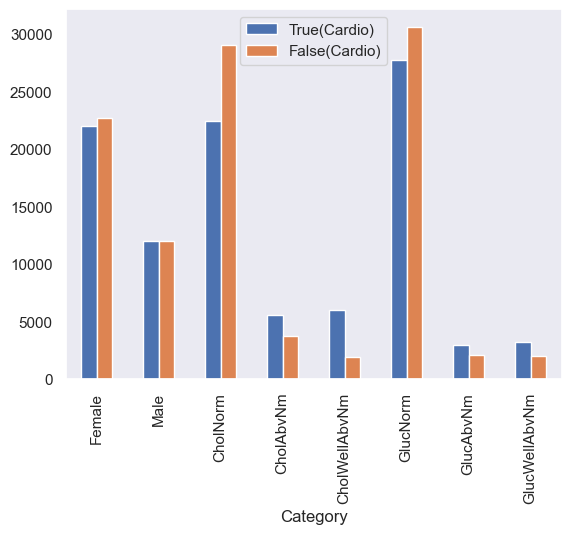

,True(Cardio),False(Cardio)
Category,,
Female,21975,22724
Male,11944,11973
CholNorm,22401,29075
CholAbvNm,5528,3755
CholWellAbvNm,5990,1867
GlucNorm,27727,30619
GlucAbvNm,2980,2084
GlucWellAbvNm,3212,1994


In [41]:
#print out relation between the categoricals to cardio. As stated above, we will ignore the other booleans. 
graphCategoryToCardio('cat', False, stfm, ['gender'], data_catFullUnchanged)

What does this mean? <br> 
1. Gender may not be a determining factor for cardiovascular disease. So we will throw it away. <br>
2. Chol and Gluc may be predictors. So we will take that into account. 

Next, I will do the plotting of binary variables against cardio just for justification's sake. 

Format: ['Yes', 'No'], ['Yes', 'No'], ['Yes', 'No']
CardioTrue:[[2825, 31094], [1742, 32177], [26740, 7179]]
CardioFalse:[[3210, 31487], [1918, 32779], [28385, 6312]]
            True(Cardio)  False(Cardio)
Category                               
SmokingYes          2825           3210
SmokingNo          31094          31487
AlcoholYes          1742           1918
AlcoholNo          32177          32779
ActiveYes          26740          28385
ActiveNo            7179           6312


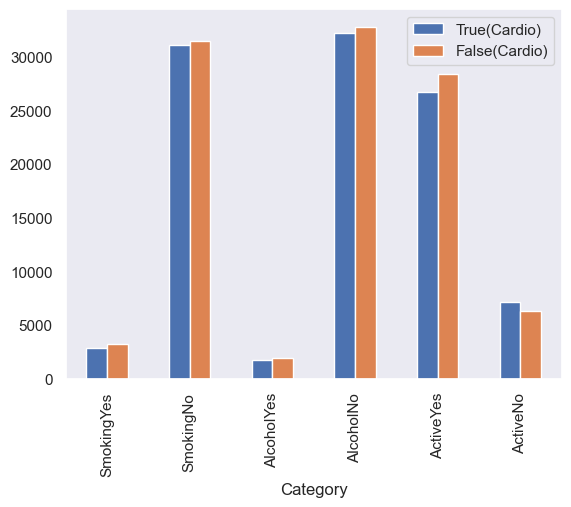

,True(Cardio),False(Cardio)
Category,,
SmokingYes,2825,3210
SmokingNo,31094,31487
AlcoholYes,1742,1918
AlcoholNo,32177,32779
ActiveYes,26740,28385
ActiveNo,7179,6312


In [42]:
graphCategoryToCardio('bin', False, stfm, ['None'], data_catFullUnchanged)

Combining the two, we get:

Format: ['Female', 'Male'], ['Norm', 'AbvNorm', 'WellAbvNorm'], ['Norm', 'AbvNorm', 'WellAbvNorm'], ['Yes', 'No'], ['Yes', 'No'], ['Yes', 'No']
CardioTrue:[[21975, 11944], [22401, 5528, 5990], [27727, 2980, 3212], [2825, 31094], [1742, 32177], [26740, 7179]]
CardioFalse:[[22724, 11973], [29075, 3755, 1867], [30619, 2084, 1994], [3210, 31487], [1918, 32779], [28385, 6312]]
               True(Cardio)  False(Cardio)
Category                                  
Female                21975          22724
Male                  11944          11973
CholNorm              22401          29075
CholAbvNm              5528           3755
CholWellAbvNm          5990           1867
GlucNorm              27727          30619
GlucAbvNm              2980           2084
GlucWellAbvNm          3212           1994
SmokingYes             2825           3210
SmokingNo             31094          31487
AlcoholYes             1742           1918
AlcoholNo             32177          32779
ActiveYes             2

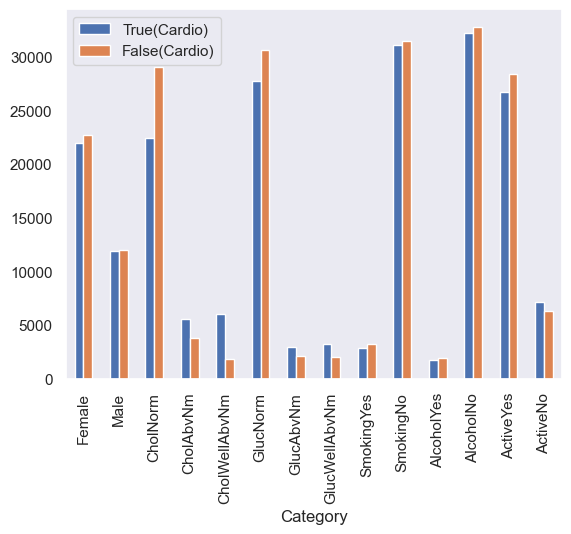

In [43]:
df_catOut = graphCategoryToCardioLst(V.get('cat') + V.get('bin'), False, stfm, ['gender'], data_catFullUnchanged)

We can see values from df returned from the graphCategory function. I will now attempt to justify why I will ignore certain variables by seeing the gaps between the True and False values. 

In [44]:
diff_df = [{df_catOut.iloc[x].name + '\'s diff' : df_catOut['True(Cardio)'][x] - df_catOut['False(Cardio)'][x]} for x in range(df_catOut.shape[0])]
#Because our sample size is over 68000, I will only consider sensible values. Consider my favourite number, 2.5%
print("Cutoff value : ", data_catFullUnchanged.shape[0] * 0.025)
groupedAbsSummationDiff(diff_df)

Cutoff value :  1715.4


{'genderDiffTrue_False': 778,
 'cholesterolDiffTrue_False': 12570,
 'glucoseDiffTrue_False': 5006,
 'smokingDiffTrue_False': 778,
 'drinksDiffTrue_False': 778,
 'isActiveDiffTrue_False': 2512}

As seen from above, we note that gender, smoking and drinking can now be ignored, since those are less than 1000 in difference. For now, we consider the active column as a predictor since it exceeds the threshold of 1.7K. 
We now split it into slices. <br>

Format: ['Norm', 'AbvNorm', 'WellAbvNorm']
CardioTrue:[[22401, 5528, 5990]]
CardioFalse:[[29075, 3755, 1867]]
               True(Cardio)  False(Cardio)
Category                                  
CholNorm              22401          29075
CholAbvNm              5528           3755
CholWellAbvNm          5990           1867


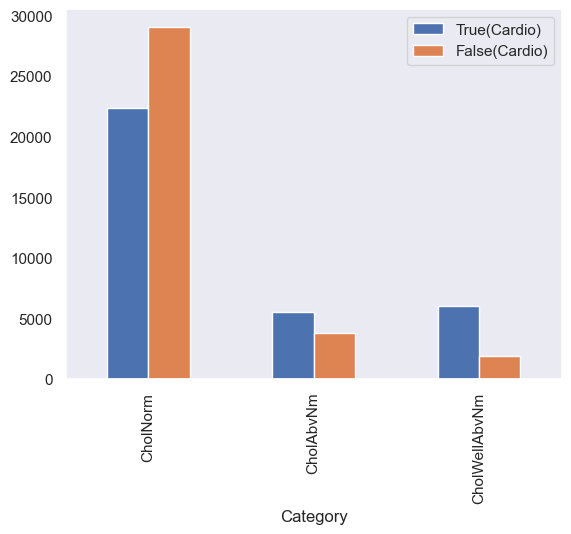

Format: ['Norm', 'AbvNorm', 'WellAbvNorm']
CardioTrue:[[27727, 2980, 3212]]
CardioFalse:[[30619, 2084, 1994]]
               True(Cardio)  False(Cardio)
Category                                  
GlucNorm              27727          30619
GlucAbvNm              2980           2084
GlucWellAbvNm          3212           1994


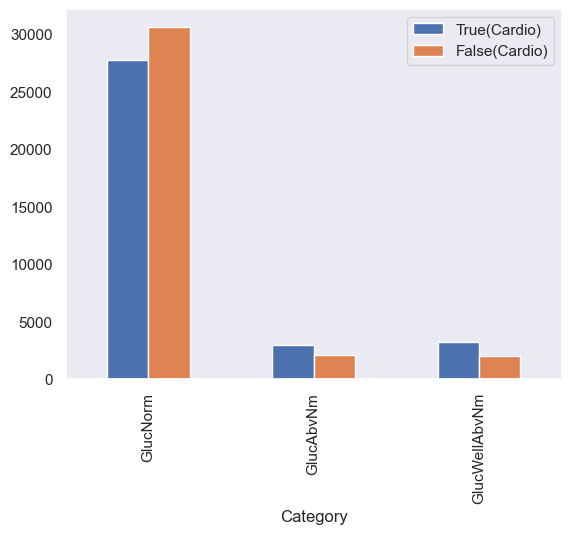

Format: ['Yes', 'No']
CardioTrue:[[26740, 7179]]
CardioFalse:[[28385, 6312]]
           True(Cardio)  False(Cardio)
Category                              
ActiveYes         26740          28385
ActiveNo           7179           6312


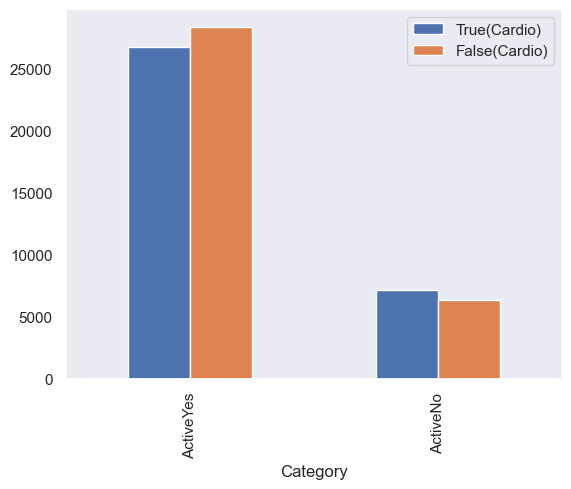

In [46]:
allowed_cats = ['cholesterol', 'gluc', 'active']
for var in allowed_cats:
    graphCategoryToCardioLst([var], False, stfm, ['None'], data_catFullUnchanged)

In [54]:
#End result:
variables_to_consider = ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'active']
#move to next notebook
%store variables_to_consider

Stored 'variables_to_consider' (list)
